# 4. 작사가 인공지능 만들기

### 학습과정

1. 데이터 다운로드
2. 데이터 읽어오기
3. 데이터 정제
4. 평가 데이터셋 분리
5. 인공지능 만들기

### 데이터 읽어오기

In [1]:
import re
import numpy as np
import tensorflow as tf
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list=  glob.glob(txt_file_path)

raw_corpus = []

#여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()  # 텍스트를 라인 단위로 끊어서 읽어오기
        raw_corpus.extend(raw)
        
print('데이터의 크기:', len(raw_corpus))
print('Examples:\n', raw_corpus[:3])

데이터의 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### 데이터 정제하기

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   #길이가 0인 문장은 건너뜁니다.
    if sentence[0] == '[': continue    # 문장 처음이 '['인 문장은 건너뜁니다.
    if sentence[-1] == ']': continue   # 문장 끝이 ']'d인 문장은 건너뜁니다.
    if idx > 10: break   #문장 10개만 확인
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof
You saw her bathing on the roof


토큰화

    1. 문장 부호 양쪽에 공백을 추가
    2. 모든 문자들을 소문자로 변환
    3. 특수문자들은 모두 제거

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()    # 소문자로 바꾸고 양족 공백을 삭제
    
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)     # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)             # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)   # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    
    sentence = sentence.strip()
    
    sentence = '<start> ' + sentence + ' <end>'       # 문자 앞뒤로 <start>와 <end> 를 단어처럼 붙여줌
    
    if "verse" in sentence:
        sentence = sentence.replace("verse", "")
    if "chorus" in sentence:
        sentence = sentence.replace("chorus", "")
        
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    a0 = preprocess_sentence(sentence)
    if len(a0.split()) > 15: continue
    corpus.append(a0)

In [5]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있음. 이번에는 사용하지 안함
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 <unk> 처리
    )
    tokenizer.fit_on_texts(corpus)   # 구축한 corpus로부터 Tokenizer가 사전을 자동구축

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환.
   
    for num in tensor:
        if len(num) >= 29:
            tensor = np.delete(tensor, num)
            
    print(len(tensor))
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

    
tensor, tokenizer = tokenize(corpus)

156262
[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  257  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7faae6447e80>


In [6]:
# 단어 사전 어떻게 생겼는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [7]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성, 마지막 토근은 <end> 가 아니라 <pad> 일 가능성이 높다.
tgt_input = tensor[:, 1:]   # tensor에서 <start>를 잘라내서 타켓 문장을 생성.


In [8]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                         tgt_input,
                                                         test_size=0.2, 
                                                         shuffle=True,
                                                         random_state=32)

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (125009, 14)
Target Train: (125009, 14)


-> 학습데이터 갯수가 124960개 이하이므로 이대로 학습을 시켜주겠습니다.

## 평가 데이터셋 만들기

In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_spoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 15000개와, 여기 포함되지 않은 0:<pad>를 포함하여 15001개

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 인공지능 만들기

In [11]:
import matplotlib.pyplot as plt
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop  = tf.keras.layers.Dropout(0.5)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.drop(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-1.79298848e-04, -2.06168101e-04, -6.66256310e-05, ...,
          2.40608460e-05,  7.80462942e-05, -7.47865051e-05],
        [-2.38764682e-04, -5.85020229e-04, -2.65241542e-04, ...,
          2.01656323e-04,  1.17529642e-04,  5.28888777e-05],
        [-5.37206419e-04, -8.79778643e-04, -1.32479880e-04, ...,
         -5.25574505e-05,  7.69210747e-05, -1.69700309e-06],
        ...,
        [-9.77793126e-04, -3.09300842e-03,  3.24535824e-04, ...,
         -2.15757615e-03,  7.98548921e-04, -6.60122430e-04],
        [-6.16260688e-04, -2.95941532e-03, -7.19935488e-05, ...,
         -2.28729961e-03,  8.30297824e-04, -6.28554320e-04],
        [-2.82949739e-04, -2.82829045e-03, -4.29448613e-04, ...,
         -2.36361101e-03,  8.69394047e-04, -5.93648234e-04]],

       [[-1.79298848e-04, -2.06168101e-04, -6.66256310e-05, ...,
          2.40608460e-05,  7.80462942e-05, -7.47865051e-05],
        [-1.21241414e-04, -3.14483070e-04, -4.

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  18882560  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  14345049  
Total params: 68,582,489
Trainable params: 68,582,489
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = []

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=5)

history = model.fit(enc_train, 
          dec_train,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/5
610/610 [==============================] - 250s 406ms/step - loss: 3.1866
Epoch 2/5
610/610 [==============================] - 248s 406ms/step - loss: 2.7339
Epoch 3/5
610/610 [==============================] - 248s 407ms/step - loss: 2.5062
Epoch 4/5
610/610 [==============================] - 248s 406ms/step - loss: 2.3040
Epoch 5/5
489/489 [==============================] - 220s 447ms/step - loss: 1.9412 - val_loss: 1.8095


In [16]:
results = model.evaluate(enc_val,  dec_val, verbose=2)

print(results)

977/977 - 33s - loss: 1.8095
1.8094978332519531


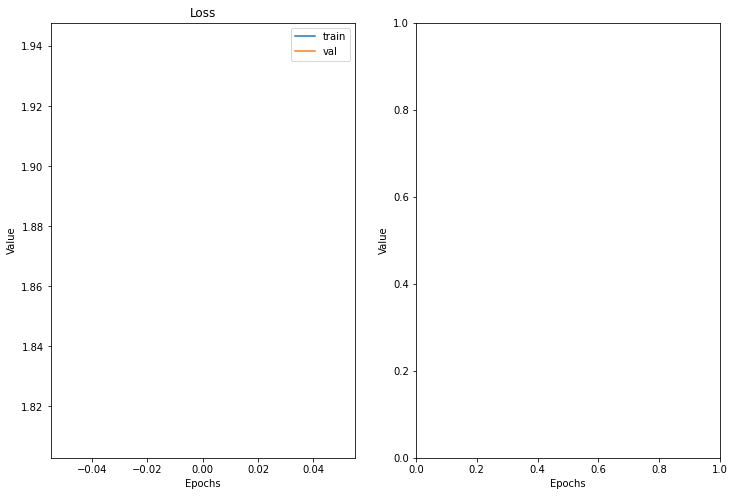

In [20]:
import matplotlib.pyplot as plt
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [19]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '

### 회고

유난히 많은 시간이 걸렸던 노드였던것같다.
자연어 처리를 노래 가사로 실험해볼 수 있던게 흥미로웠다.
인공지능은 결국 사람을 모방한 것이므로 사람이 언어를 인식하는 방식과 유사해질수록 인공지능의 성능이 높아지지 않을까 하는 생각을 했다.
loss 값을 2.2 이하로 떨어뜨리기 위해 epoch, embedding_size, hidden_size 값을 수정했다.
epoch를 제외하고 주로 증가를 하는 방향으로 갔던 것 같다. 
처음엔 epoch 값을 10, 30으로도 해보았지만 시간이 너무 오래 걸려 최소한의 epoch로 loss 값을 2.2 이하로 맞추는 값을 찾기 위해 수정을 가했다.
